In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-oe3so9h2
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-oe3so9h2
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=92b77327fb4ae805794f53bfe831dba4c6a0eb0f251368c24f0340d0eaa1af85
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghpm5fc1/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

## Helper Function

In [ ]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')
    
    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')
    
    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

## Generator

In [ ]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d
    
    # Input Layer
    in_img = Input(shape=img_shape)
    
    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)
    
    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)
    
    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
    
    return Model(in_img, out_img, name='generator')

## Discriminator

In [ ]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d
    
    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)
    
    merged = Concatenate()([in_src_img, in_target_img])
    
    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    
    return Model([in_src_img, in_target_img], out, name='discriminator')

## GAN

In [ ]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

## Train GAN model

In [ ]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    blue_photo = data[0]
    blue_sketch = data[1]
    
    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')
        
        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):
            
            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))
            
            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            
            d_loss = 0.5 * np.add(d_loss1, d_loss2)
            
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            
            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))
        
        # summarize model performance
#         if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, target_dir)

## Loss Function

In [ ]:
#downgrading tensorflow
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true, 
                                [0,0,0,0], 
                                [16, 256, 256, 3]))
    
    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)
    
#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)
    
    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)
    
    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))
    
    return tf.reduce_sum(tf.multiply(p_, tf.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)
    
    return (0.2 * px_loss) + (0.8 * ctx_loss)

Instructions for updating:
non-resource variables are not supported in the long term


## Load Dataset

In [ ]:
# dataset path
b_photo_path = '/content/gdrive/MyDrive/FaceCreation_ACM_Project/Face-Sketch-to-Image-Generation-using-GAN-master/Dataset/Augmented_photo/'
b_sketch_path = '/content/gdrive/MyDrive/FaceCreation_ACM_Project/Face-Sketch-to-Image-Generation-using-GAN-master/Dataset/Augmented_sketch/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

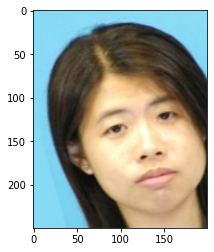

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))

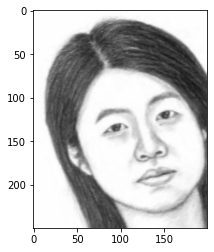

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))

## Define GAN Model

In [ ]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [ ]:
gan_model.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 generator (Functional)         (None, 256, 256, 3)  41825691    ['input_4[0][0]']                
                                                                                                  
 discriminator (Functional)     (None, 64, 64, 1)    539203      ['input_4[0][0]',                
                                                                  'generator[0][0]']              
                                                                                                

In [ ]:
len(g_model.layers)

50

In [ ]:
len(d_model.layers)

9

In [ ]:
len(gan_model.layers)

3

In [ ]:
opt = Adam(lr=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Start Training

In [ ]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], 'Models/Pixel[02]_Context[08]/', n_epochs = 100, n_batch=16)

 ========== Epoch 1 ========== 
Batch : 1, D Loss : 3.603 | G Loss : 3.761
Batch : 2, D Loss : 3.402 | G Loss : 3.961
Batch : 3, D Loss : 3.538 | G Loss : 3.483
Batch : 4, D Loss : 3.543 | G Loss : 4.131
Batch : 5, D Loss : 3.349 | G Loss : 3.830
Batch : 6, D Loss : 3.490 | G Loss : 4.056
Batch : 7, D Loss : 3.485 | G Loss : 3.975
Batch : 8, D Loss : 3.452 | G Loss : 3.682
Batch : 9, D Loss : 3.457 | G Loss : 3.506
Batch : 10, D Loss : 3.465 | G Loss : 3.849
Batch : 11, D Loss : 3.502 | G Loss : 3.389
Batch : 12, D Loss : 3.507 | G Loss : 3.837
Batch : 13, D Loss : 3.553 | G Loss : 3.729
Batch : 14, D Loss : 3.372 | G Loss : 3.741
Batch : 15, D Loss : 3.508 | G Loss : 3.986
Batch : 16, D Loss : 3.547 | G Loss : 3.625
Batch : 17, D Loss : 3.467 | G Loss : 4.336
Batch : 18, D Loss : 3.388 | G Loss : 4.447
Batch : 19, D Loss : 3.488 | G Loss : 4.268
Batch : 20, D Loss : 3.496 | G Loss : 3.820
Batch : 21, D Loss : 3.460 | G Loss : 3.778
Batch : 22, D Loss : 3.494 | G Loss : 3.787
Batch : 2

KeyboardInterrupt: ignored

In [ ]:
g_model_json = g_model.to_json()
with open("g_model.json", "w") as json_file:
    json_file.write(g_model_json)
d_model_json = d_model.to_json()
with open("d_model.json", "w") as json_file:
    json_file.write(d_model_json)

In [ ]:
# saving model to H5
g_model.save("g_model1.h5")
d_model.save("d_model1.h5")
print("Saved model to disk")

Saved model to disk
